# Final Year Project (Self Driving Cars)

# Import Libraries

In [74]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json

# Data preprocessing

# Load and Preprocess data

In [3]:
# Load and preprocess data
def load_and_preprocess_data(data_folder):
    data = []
    
    for filename in os.listdir(data_folder):
        if filename.endswith("_preprocessed.npy"):
            file_path = os.path.join(data_folder, filename)
            item = np.load(file_path, allow_pickle=True).item()
            data.append(item)
    return data

# Set path to the folder containing preprocessed data
preprocessed_data_folder = "C:/Users/jacky/OneDrive/Desktop/dataset/preprocessed_data"

# Load and preprocess data
all_data = load_and_preprocess_data(preprocessed_data_folder)
subset_size = 2000  # Number of images in the subset

all_data = all_data[:subset_size]

# Split data into train, validation, and test sets
train_size = int(0.7 * len(all_data))
val_size = int(0.1 * len(all_data))

train_data = all_data[:train_size]
val_data = all_data[train_size:train_size + val_size]
test_data = all_data[train_size + val_size:]

# Create empty lists for train_images, train_masks, val_images, and val_masks
train_images = []
train_masks = []
val_images = []
val_masks = []
test_images = []
test_masks = []

# Load and preprocess data in batches
for item in train_data:
    train_images.append(item["image"])
    train_masks.append(item["mask"])

for item in val_data:
    val_images.append(item["image"])
    val_masks.append(item["mask"])
    
for item in test_data:
    test_images.append(item["image"])
    test_masks.append(item["mask"])
    
# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Check preprocessed dataset

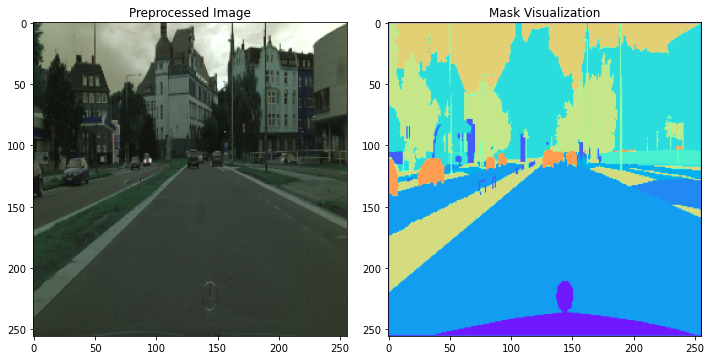

In [9]:
# Path to the folder containing preprocessed data
preprocessed_data_folder = "C:/Users/jacky/OneDrive/Desktop/dataset/preprocessed_data"

# Load a sample preprocessed data file
sample_file = os.path.join(preprocessed_data_folder, "aachen_000001_000019_leftImg8bit.png_preprocessed.npy")
sample_data = np.load(sample_file, allow_pickle=True).item()

# Extract the preprocessed image and mask from the sample data
preprocessed_image = sample_data["image"]
mask = sample_data["mask"]

# Create a colormap for the classes
num_classes = mask.shape[-1]
cmap = plt.cm.get_cmap("rainbow", num_classes)

# Create a combined mask visualization using colors
combined_mask = np.argmax(mask, axis=-1)  # Convert one-hot encoded mask to class indices
mask_visualization = cmap(combined_mask)

# Visualize the preprocessed image and the mask visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_visualization)
plt.title("Mask Visualization")

# Show the visualization
plt.tight_layout()
plt.show()


# Training

# 1.1 First Iteration

In [5]:
# Define U-Net architecture
def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Expansive path
    upconv1 = UpSampling2D(size=(2, 2))(pool1)
    concat1 = Concatenate()([conv1, upconv1])
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv3 = Conv2D(num_classes, 1, activation='softmax')(conv2)

    model = Model(inputs=inputs, outputs=conv3)
    return model

# Set input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 34 

# Build U-Net model
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=num_classes)])
##
# Create TensorFlow datasets for training, validation, and testing
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=train_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    train_datagen.flow(train_images, train_masks, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_images) // batch_size
)

# Save the model architecture to a JSON file
model_architecture = model.to_json()
model_filename = "unet_model_architecture.json"
with open(model_filename, "w") as json_file:
    json_file.write(model_architecture)

# Save the trained weights to an HDF5 file
model_weights_filename = "unet_model_weights.h5"
model.save_weights(model_weights_filename)

# Evaluate the model on the testing dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_dataset, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test IoU:", test_iou)


Epoch 1/20
175/175 [==============================] - 390s 2s/step - loss: 2.6874 - accuracy: 0.4854 - mean_io_u: 0.4848 - val_loss: 3.4322 - val_accuracy: 1.4954e-05 - val_mean_io_u: 0.4848
Epoch 2/20
175/175 [==============================] - 372s 2s/step - loss: 1.9750 - accuracy: 0.5131 - mean_io_u: 0.4848 - val_loss: 3.0932 - val_accuracy: 1.4954e-05 - val_mean_io_u: 0.4848
Epoch 3/20
175/175 [==============================] - 388s 2s/step - loss: 1.8693 - accuracy: 0.5143 - mean_io_u: 0.4848 - val_loss: 3.0501 - val_accuracy: 0.0028 - val_mean_io_u: 0.4848
Epoch 4/20
175/175 [==============================] - 393s 2s/step - loss: 1.8081 - accuracy: 0.5156 - mean_io_u: 0.4848 - val_loss: 2.9590 - val_accuracy: 0.0032 - val_mean_io_u: 0.4848
Epoch 5/20
175/175 [==============================] - 393s 2s/step - loss: 1.7751 - accuracy: 0.5162 - mean_io_u: 0.4848 - val_loss: 2.9366 - val_accuracy: 0.0041 - val_mean_io_u: 0.4848
Epoch 6/20
175/175 [==============================] - 391

# 1.2 Evaluation

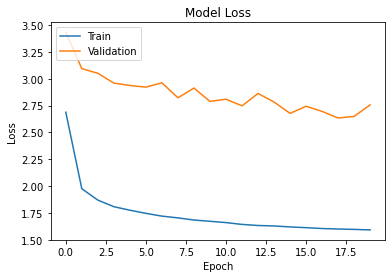

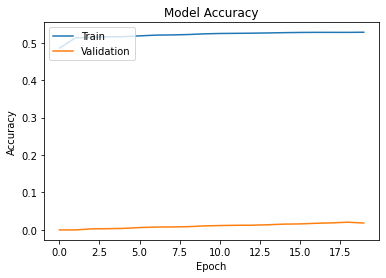

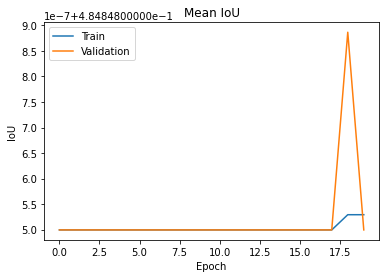

In [12]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation IoU values
plt.plot(history.history['mean_io_u']) 
plt.plot(history.history['val_mean_io_u'])  
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 1.3 Visualize 

1/1 [==============================] - 0s 328ms/step


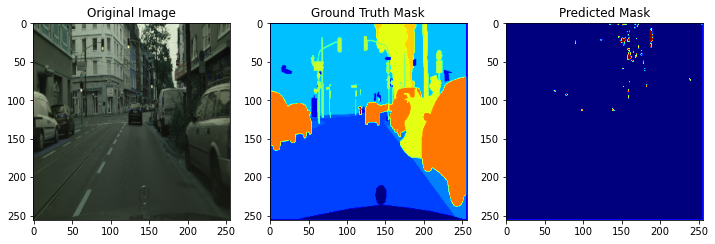

In [76]:
# Load the model architecture from the JSON file
with open('unet_model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Reconstruct the model from the JSON file
loaded_model = model_from_json(loaded_model_json)

# Load the trained weights
loaded_model.load_weights('unet_model_weights.h5')

# Choose an image from the testing dataset
sample_image = test_images[0]  

# Make a prediction using the loaded model
predicted_mask = loaded_model.predict(np.expand_dims(sample_image, axis=0))[0]

# Visualize the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(sample_image)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(np.argmax(test_masks[0], axis=-1), cmap='jet')
plt.title('Ground Truth Mask')
plt.subplot(133)
plt.imshow(np.argmax(predicted_mask, axis=-1), cmap='jet')
plt.title('Predicted Mask')
plt.show()


# 2.1 Second iteration

In [10]:
# Define U-Net architecture with increased capacity
def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Expansive path
    upconv1 = UpSampling2D(size=(2, 2))(pool1)
    concat1 = Concatenate()([conv1, upconv1])
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv3 = Conv2D(num_classes, 1, activation='softmax')(conv2)

    model = Model(inputs=inputs, outputs=conv3)
    return model

# Set input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 34 

# Build U-Net model
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=num_classes)])
##
# Create TensorFlow datasets for training, validation, and testing
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=train_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    train_datagen.flow(train_images, train_masks, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_images) // batch_size
)

# Save the model architecture to a JSON file
model_architecture = model.to_json()
model_filename = "unet_model_architecture_2.0.json"
with open(model_filename, "w") as json_file:
    json_file.write(model_architecture)

# Save the trained weights to an HDF5 file
model_weights_filename = "unet_model_weights_2.0.h5"
model.save_weights(model_weights_filename)

# Evaluate the model on the testing dataset

test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)

y_true = []  # List to store true labels
y_pred = []  # List to store predicted labels

for image, mask in test_dataset:
    prediction = model.predict(image)
    
    # Assuming your masks are one-hot encoded, convert them to class labels
    true_label = np.argmax(mask, axis=-1)
    predicted_label = np.argmax(prediction, axis=-1)
    
    # Flatten the labels
    true_label = true_label.flatten()
    predicted_label = predicted_label.flatten()
    
    # Append the true and predicted labels to the respective lists
    y_true.extend(true_label)
    y_pred.extend(predicted_label)

# Now, y_true and y_pred contain the true and predicted labels as lists of integers

# Compute precision, recall, and F1-score
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1_score = f1_score(y_true, y_pred, average='weighted')

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test IoU:", test_iou)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)


Epoch 1/20
175/175 [==============================] - 655s 4s/step - loss: 1.9196 - accuracy: 0.5155 - mean_io_u_3: 0.4848 - val_loss: 2.5532 - val_accuracy: 0.0157 - val_mean_io_u_3: 0.4848
Epoch 2/20
175/175 [==============================] - 647s 4s/step - loss: 1.6210 - accuracy: 0.5264 - mean_io_u_3: 0.4849 - val_loss: 2.8462 - val_accuracy: 0.0222 - val_mean_io_u_3: 0.4849
Epoch 3/20
175/175 [==============================] - 644s 4s/step - loss: 1.5618 - accuracy: 0.5334 - mean_io_u_3: 0.4849 - val_loss: 2.2890 - val_accuracy: 0.1067 - val_mean_io_u_3: 0.4850
Epoch 4/20
175/175 [==============================] - 654s 4s/step - loss: 1.5561 - accuracy: 0.5363 - mean_io_u_3: 0.4852 - val_loss: 2.6285 - val_accuracy: 0.0248 - val_mean_io_u_3: 0.4855
Epoch 5/20
175/175 [==============================] - 656s 4s/step - loss: 1.5294 - accuracy: 0.5340 - mean_io_u_3: 0.4854 - val_loss: 2.9748 - val_accuracy: 0.0256 - val_mean_io_u_3: 0.4859
Epoch 6/20
175/175 [=========================

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 2.0636184215545654
Test Accuracy: 0.17166602611541748
Test IoU: 0.48610177636146545
Test Precision: 0.646382972614471
Test Recall: 0.10674942016601563
Test F1 Score: 0.15799688717237567


# 2.2 Evaluation

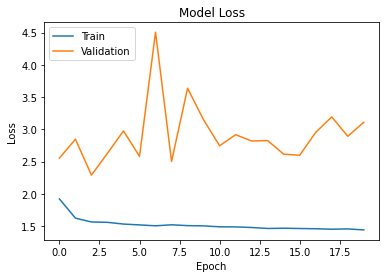

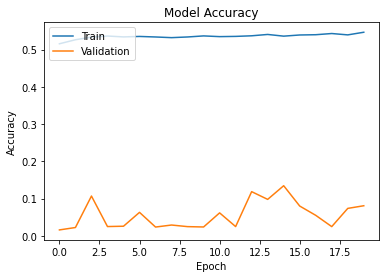

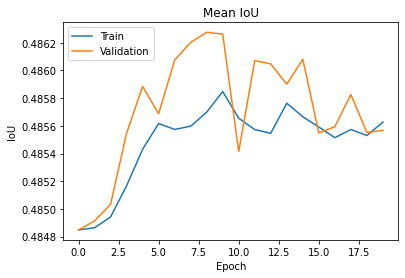

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation IoU values
plt.plot(history.history['mean_io_u_3']) 
plt.plot(history.history['val_mean_io_u_3'])  
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 2.3 Visualize

1/1 [==============================] - 0s 123ms/step


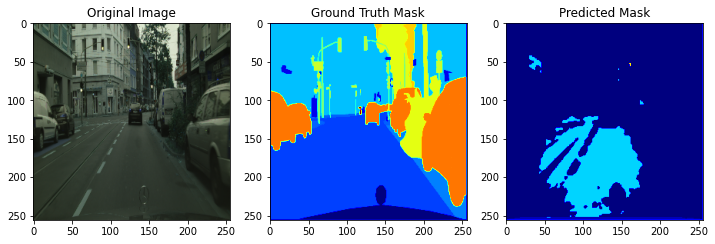

In [49]:
# Load the model architecture from the JSON file
with open('unet_model_architecture_2.0.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Reconstruct the model from the JSON file
loaded_model = model_from_json(loaded_model_json)

# Load the trained weights
loaded_model.load_weights('unet_model_weights_2.0.h5')

# Choose an image from the testing dataset
sample_image = test_images[0]  # You can choose any index

# Make a prediction using the loaded model
predicted_mask = loaded_model.predict(np.expand_dims(sample_image, axis=0))[0]

# Visualize the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(sample_image)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(np.argmax(test_masks[0], axis=-1), cmap='jet')
plt.title('Ground Truth Mask')
plt.subplot(133)
plt.imshow(np.argmax(predicted_mask, axis=-1), cmap='jet')
plt.title('Predicted Mask')
plt.show()


# 3.1 Third iteration 

In [60]:
# Define U-Net architecture with increased capacity
def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Contracting path
    s1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    s1 = Conv2D(64, 3, activation='relu', padding='same')(s1)
    p1 = MaxPooling2D(pool_size=(2, 2))(s1)
    
    s2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    s2 = Conv2D(128, 3, activation='relu', padding='same')(s2)
    p2 = MaxPooling2D(pool_size=(2, 2))(s2)
    
    s3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    s3 = Conv2D(256, 3, activation='relu', padding='same')(s3)
    p3 = MaxPooling2D(pool_size=(2, 2))(s3)
    
    s4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    s4 = Conv2D(512, 3, activation='relu', padding='same')(s4)
    p4 = MaxPooling2D(pool_size=(2, 2))(s4)
    
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(b1)

    # Expansive path
    d1 = Conv2D(512, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(b1))
    d1 = Concatenate()([s4, d1])
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)
    
    d2 = Conv2D(256, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(d1))
    d2 = Concatenate()([s3, d2])
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)
    
    d3 = Conv2D(128, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(d2))
    d3 = Concatenate()([s2, d3])
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)
    
    d4 = Conv2D(64, 3, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(d3))
    d4 = Concatenate()([s1, d4])
    d4 = Conv2D(64, 3, activation='relu', padding='same')(d4)
    d4 = Conv2D(64, 3, activation='relu', padding='same')(d4)
    out = Conv2D(num_classes, 1, activation='softmax')(d4)

    model = Model(inputs=inputs, outputs=out)
    return model

# Set input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 34 

# Build U-Net model
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=num_classes)])
##
# Create TensorFlow datasets for training, validation, and testing
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=train_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    train_datagen.flow(train_images, train_masks, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_images) // batch_size
)

# Save the model architecture to a JSON file
model_architecture = model.to_json()
model_filename = "unet_model_architecture_3.0.json"
with open(model_filename, "w") as json_file:
    json_file.write(model_architecture)

# Save the trained weights to an HDF5 file
model_weights_filename = "unet_model_weights_3.0.h5"
model.save_weights(model_weights_filename)

# Evaluate the model on the testing dataset

test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)

y_true = []  # List to store true labels
y_pred = []  # List to store predicted labels

for image, mask in test_dataset:
    prediction = model.predict(image)
    
    # Assuming your masks are one-hot encoded, convert them to class labels
    true_label = np.argmax(mask, axis=-1)
    predicted_label = np.argmax(prediction, axis=-1)
    
    # Flatten the labels
    true_label = true_label.flatten()
    predicted_label = predicted_label.flatten()
    
    # Append the true and predicted labels to the respective lists
    y_true.extend(true_label)
    y_pred.extend(predicted_label)

# Now, y_true and y_pred contain the true and predicted labels as lists of integers

# Compute precision, recall, and F1-score
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1_score = f1_score(y_true, y_pred, average='weighted')

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test IoU:", test_iou)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)


Epoch 1/20
175/175 [==============================] - 2370s 14s/step - loss: 3.0325 - accuracy: 0.4880 - mean_io_u_4: 0.4870 - val_loss: 2.8041 - val_accuracy: 0.0269 - val_mean_io_u_4: 0.4848
Epoch 2/20
175/175 [==============================] - 2420s 14s/step - loss: 1.6492 - accuracy: 0.5392 - mean_io_u_4: 0.4850 - val_loss: 2.7436 - val_accuracy: 0.0448 - val_mean_io_u_4: 0.4856
Epoch 3/20
175/175 [==============================] - 2690s 15s/step - loss: 1.4554 - accuracy: 0.5492 - mean_io_u_4: 0.4857 - val_loss: 2.9712 - val_accuracy: 0.0445 - val_mean_io_u_4: 0.4860
Epoch 4/20
175/175 [==============================] - 2604s 15s/step - loss: 1.3188 - accuracy: 0.5517 - mean_io_u_4: 0.4855 - val_loss: 2.2069 - val_accuracy: 0.1884 - val_mean_io_u_4: 0.4851
Epoch 5/20
175/175 [==============================] - 2645s 15s/step - loss: 1.2803 - accuracy: 0.5552 - mean_io_u_4: 0.4855 - val_loss: 2.0674 - val_accuracy: 0.1792 - val_mean_io_u_4: 0.4859
Epoch 6/20
175/175 [===============

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.7976019382476807
Test Accuracy: 0.1922549456357956
Test IoU: 0.48678696155548096
Test Precision: 0.6954364620905717
Test Recall: 0.19225494384765626
Test F1 Score: 0.2645577986224205


# 3.2 Evaluation

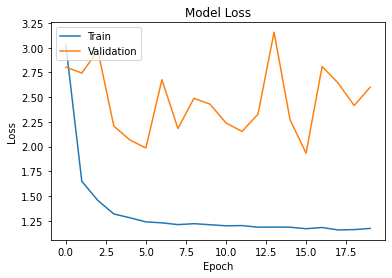

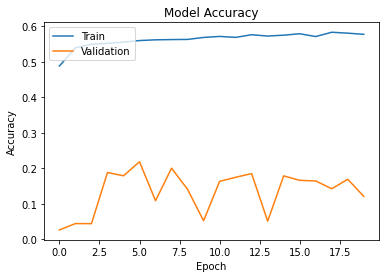

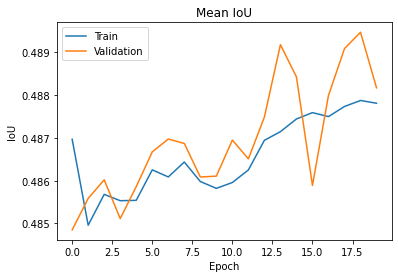

In [72]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation IoU values
plt.plot(history.history['mean_io_u_4']) 
plt.plot(history.history['val_mean_io_u_4'])  
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3.3 Visualize

1/1 [==============================] - 2s 2s/step


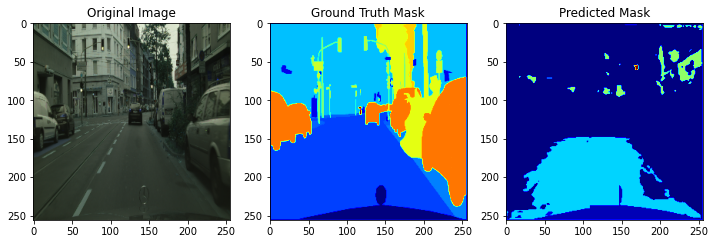

In [75]:
# Load the model architecture from the JSON file
with open('unet_model_architecture_3.0.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Reconstruct the model from the JSON file
loaded_model = model_from_json(loaded_model_json)

# Load the trained weights
loaded_model.load_weights('unet_model_weights_3.0.h5')

# Choose an image from the testing dataset
sample_image = test_images[0]  # You can choose any index

# Make a prediction using the loaded model
predicted_mask = loaded_model.predict(np.expand_dims(sample_image, axis=0))[0]

# Visualize the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(sample_image)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(np.argmax(test_masks[0], axis=-1), cmap='jet')
plt.title('Ground Truth Mask')
plt.subplot(133)
plt.imshow(np.argmax(predicted_mask, axis=-1), cmap='jet')
plt.title('Predicted Mask')
plt.show()
